This notebook is used to explore the derivative estimation by regression using some toy probability models.

By definition, the Jacobian matrix at the maximum should be zero and the curvature matrix should be negative (semi)definite.
However, there is a case that I tried using the MCMC samples of some real world problem where this estimated derivative doesn't behave as expected at the maximum.
Thus, I want to explore this issue using some toy models.

In [1]:
import numpy as np
from scipy import stats
import numdifftools as nd
import matplotlib.pyplot as plt
from corner import corner

import sensitivity_regression as sr
from utils import normalize_samples, get_samples_subset

seed = 1717
np.random.seed(seed)

%matplotlib inline
plt.style.use("default")

# Generate artificial samples: Multivariate normal

This is a simple toy model that we understand really well.

In [2]:
ndim = 10
nsamples = 10_000

mean = np.random.uniform(-10, 10, ndim)
rand_mat = np.random.uniform(-2, 2, (ndim, ndim))
cov = rand_mat.T @ rand_mat
dist = stats.multivariate_normal(mean=mean, cov=cov, seed=seed)
X = dist.rvs(nsamples)
Q = dist.logpdf(X)

## Evaluation point: the actual maximum

In [3]:
X0 = mean
Q0 = np.array([dist.logpdf(X0)])
S1_temp, S2_temp = sr.first_second_order(X0, Q0, X, Q)
S1 = S1_temp * np.exp(Q0)
S2 = np.exp(Q0) * (S2_temp + S1.T @ S1)

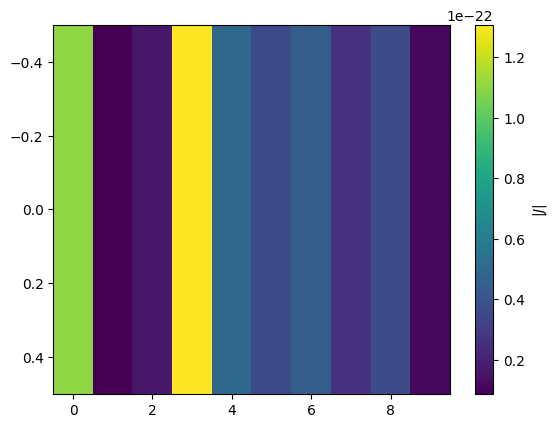

In [4]:
# Plot the Jacobian
plt.figure()
im = plt.imshow(np.abs(S1), aspect="auto")
clb = plt.colorbar(im)
clb.set_label(r"$\vert J \vert$")
plt.show()

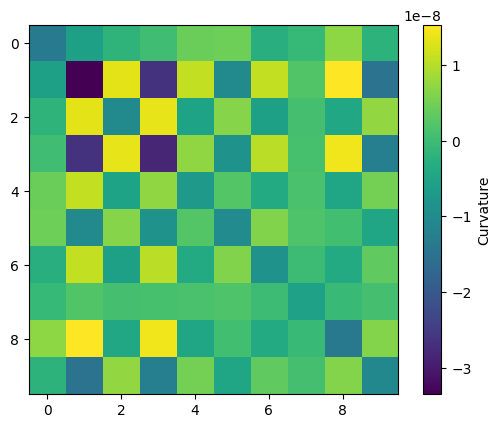

In [5]:
# Plot the curvature
plt.figure()
im = plt.imshow(S2[0])
clb = plt.colorbar(im)
clb.set_label("Curvature")
plt.show()

In [6]:
# Singular value of the Jacobian
print("Singular value of the Jacobian:", np.linalg.svd(S1, compute_uv=False))
# Eigenvalues of the curvature matrix
print("Eigenvalues of the Hessian:")
print(np.linalg.eigvalsh(S2[0]))

Singular value of the Jacobian: [1.93830302e-22]
Eigenvalues of the Hessian:
[-8.92574677e-08 -2.35480493e-08 -8.61128391e-09 -7.65501047e-09
 -5.75631560e-09 -1.90339702e-09 -1.65196998e-09 -1.44074135e-09
 -8.57402729e-10 -5.79814133e-10]


In this case, both the Jacobian and the Hessian behave like we expect.
Although the Jacobian is not quite zero, but it is small enough and within some numerical precision.
The Hessian, on the other hand, is also a negative definite matrix, within some numerical error.

In [7]:
# Numdifftools
J = nd.Jacobian(dist.pdf, step=0.1 * X0)(X0)
print(J)

[[-0. -0.  0. -0. -0. -0. -0.  0.  0.  0.]]


[-5.91509388e-08 -2.03394698e-08 -6.91390547e-09 -5.82383435e-09
 -4.42899407e-09 -1.62020087e-09 -1.50197327e-09 -1.22526290e-09
 -9.64126715e-10 -7.20151490e-10]


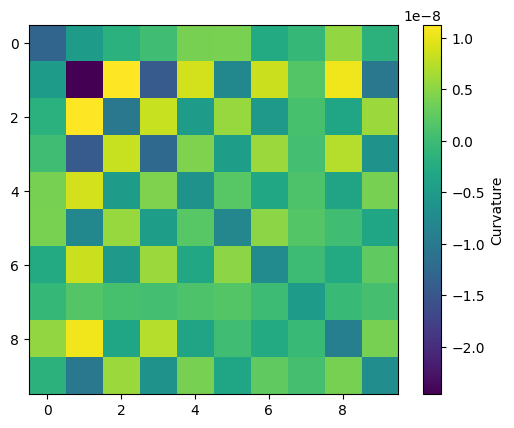

In [8]:
H = nd.Hessian(dist.pdf, step=0.1 * X0)(X0)
print(np.linalg.eigvalsh(H))

plt.figure()
im = plt.imshow(H)
clb = plt.colorbar(im)
clb.set_label("Curvature")
plt.show()

## Evaluation point: the samples maximum

In [9]:
idx_max = np.argmax(Q)
X0 = X[idx_max]
Q0 = np.array([Q[idx_max]])
S1_temp, S2_temp = sr.first_second_order(X0, Q0, X, Q)
S1 = S1_temp * np.exp(Q0)
S2 = np.exp(Q0) * (S2_temp + S1.T @ S1)

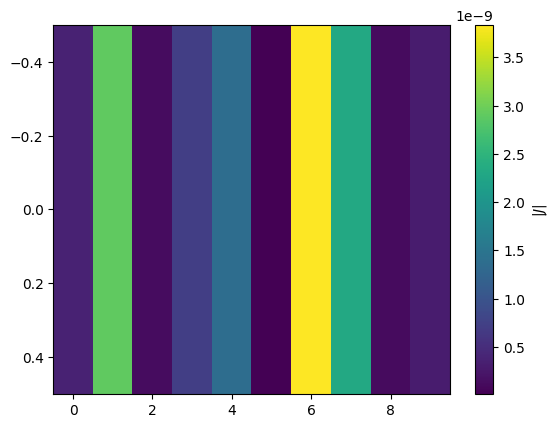

In [10]:
# Plot the Jacobian
plt.figure()
im = plt.imshow(np.abs(S1), aspect="auto")
clb = plt.colorbar(im)
clb.set_label(r"$\vert J \vert$")
plt.show()

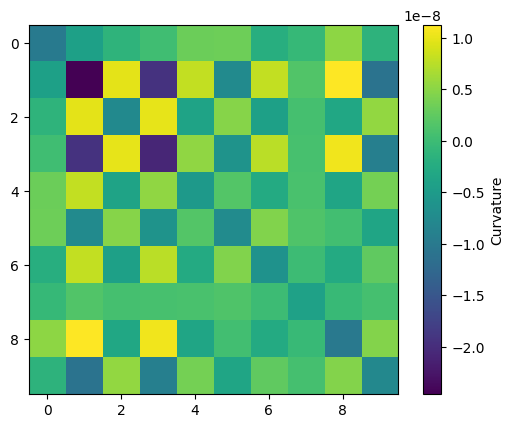

In [11]:
# Plot the curvature
plt.figure()
im = plt.imshow(S2[0])
clb = plt.colorbar(im)
clb.set_label("Curvature")
plt.show()

In [12]:
# Singular value of the Jacobian
print("Singular value of the Jacobian:", np.linalg.svd(S1, compute_uv=False))
# Eigenvalues of the curvature matrix
print("Eigenvalues of the Hessian:")
print(np.linalg.eigvalsh(S2[0]))

Singular value of the Jacobian: [5.59051896e-09]
Eigenvalues of the Hessian:
[-6.55436166e-08 -1.72918228e-08 -6.32344503e-09 -5.62123354e-09
 -4.22698237e-09 -1.39770405e-09 -1.21307594e-09 -1.05796636e-09
 -6.29608672e-10 -4.25769587e-10]


In [13]:
# Numdifftools
J = nd.Jacobian(dist.pdf, step=0.1 * X0)(X0)
print(J)

[[-3.65566112e-10  2.39948733e-09  1.29282577e-10  4.73559286e-10
  -1.32037364e-09 -9.39937164e-12 -3.65283904e-09 -2.11265289e-09
  -9.41357761e-11  2.46301879e-10]]


[-4.37010118e-08 -1.53074097e-08 -5.00724662e-09 -4.36656323e-09
 -3.07078099e-09 -1.13844821e-09 -9.36952104e-10 -7.87370463e-10
 -5.57856636e-10 -4.25002695e-10]


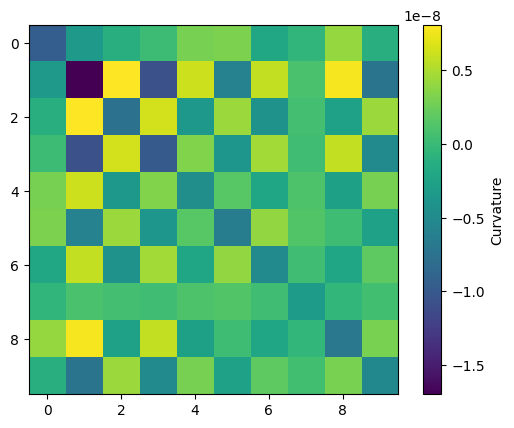

In [14]:
H = nd.Hessian(dist.pdf, step=0.1 * X0)(X0)
print(np.linalg.eigvalsh(H))

plt.figure()
im = plt.imshow(H)
clb = plt.colorbar(im)
clb.set_label("Curvature")
plt.show()

In [15]:
# Compare the mean
print("Samples max:", X0)
print("Actual max:", mean)

Samples max: [-2.76420108 -5.07221031  1.35650572 -8.30413793 -5.53458263 -5.51753265
 -5.2325515   9.00458733  8.13898095  9.61658407]
Actual max: [-2.89051115 -4.70102953  1.15817139 -8.85252195 -5.71820636 -7.06973165
 -6.96146445  7.860447    8.62709277  9.89310191]


Even when the maximum is inferred from the samples, we still see that the estimated derivatives behave as expected.
Maybe this is because multivariate Gaussian is just a simple example.
Although the actual mean and the inferred mean are not quite the same, they are close enough.
The behavior of the distribution near the maximum is approximately the same.

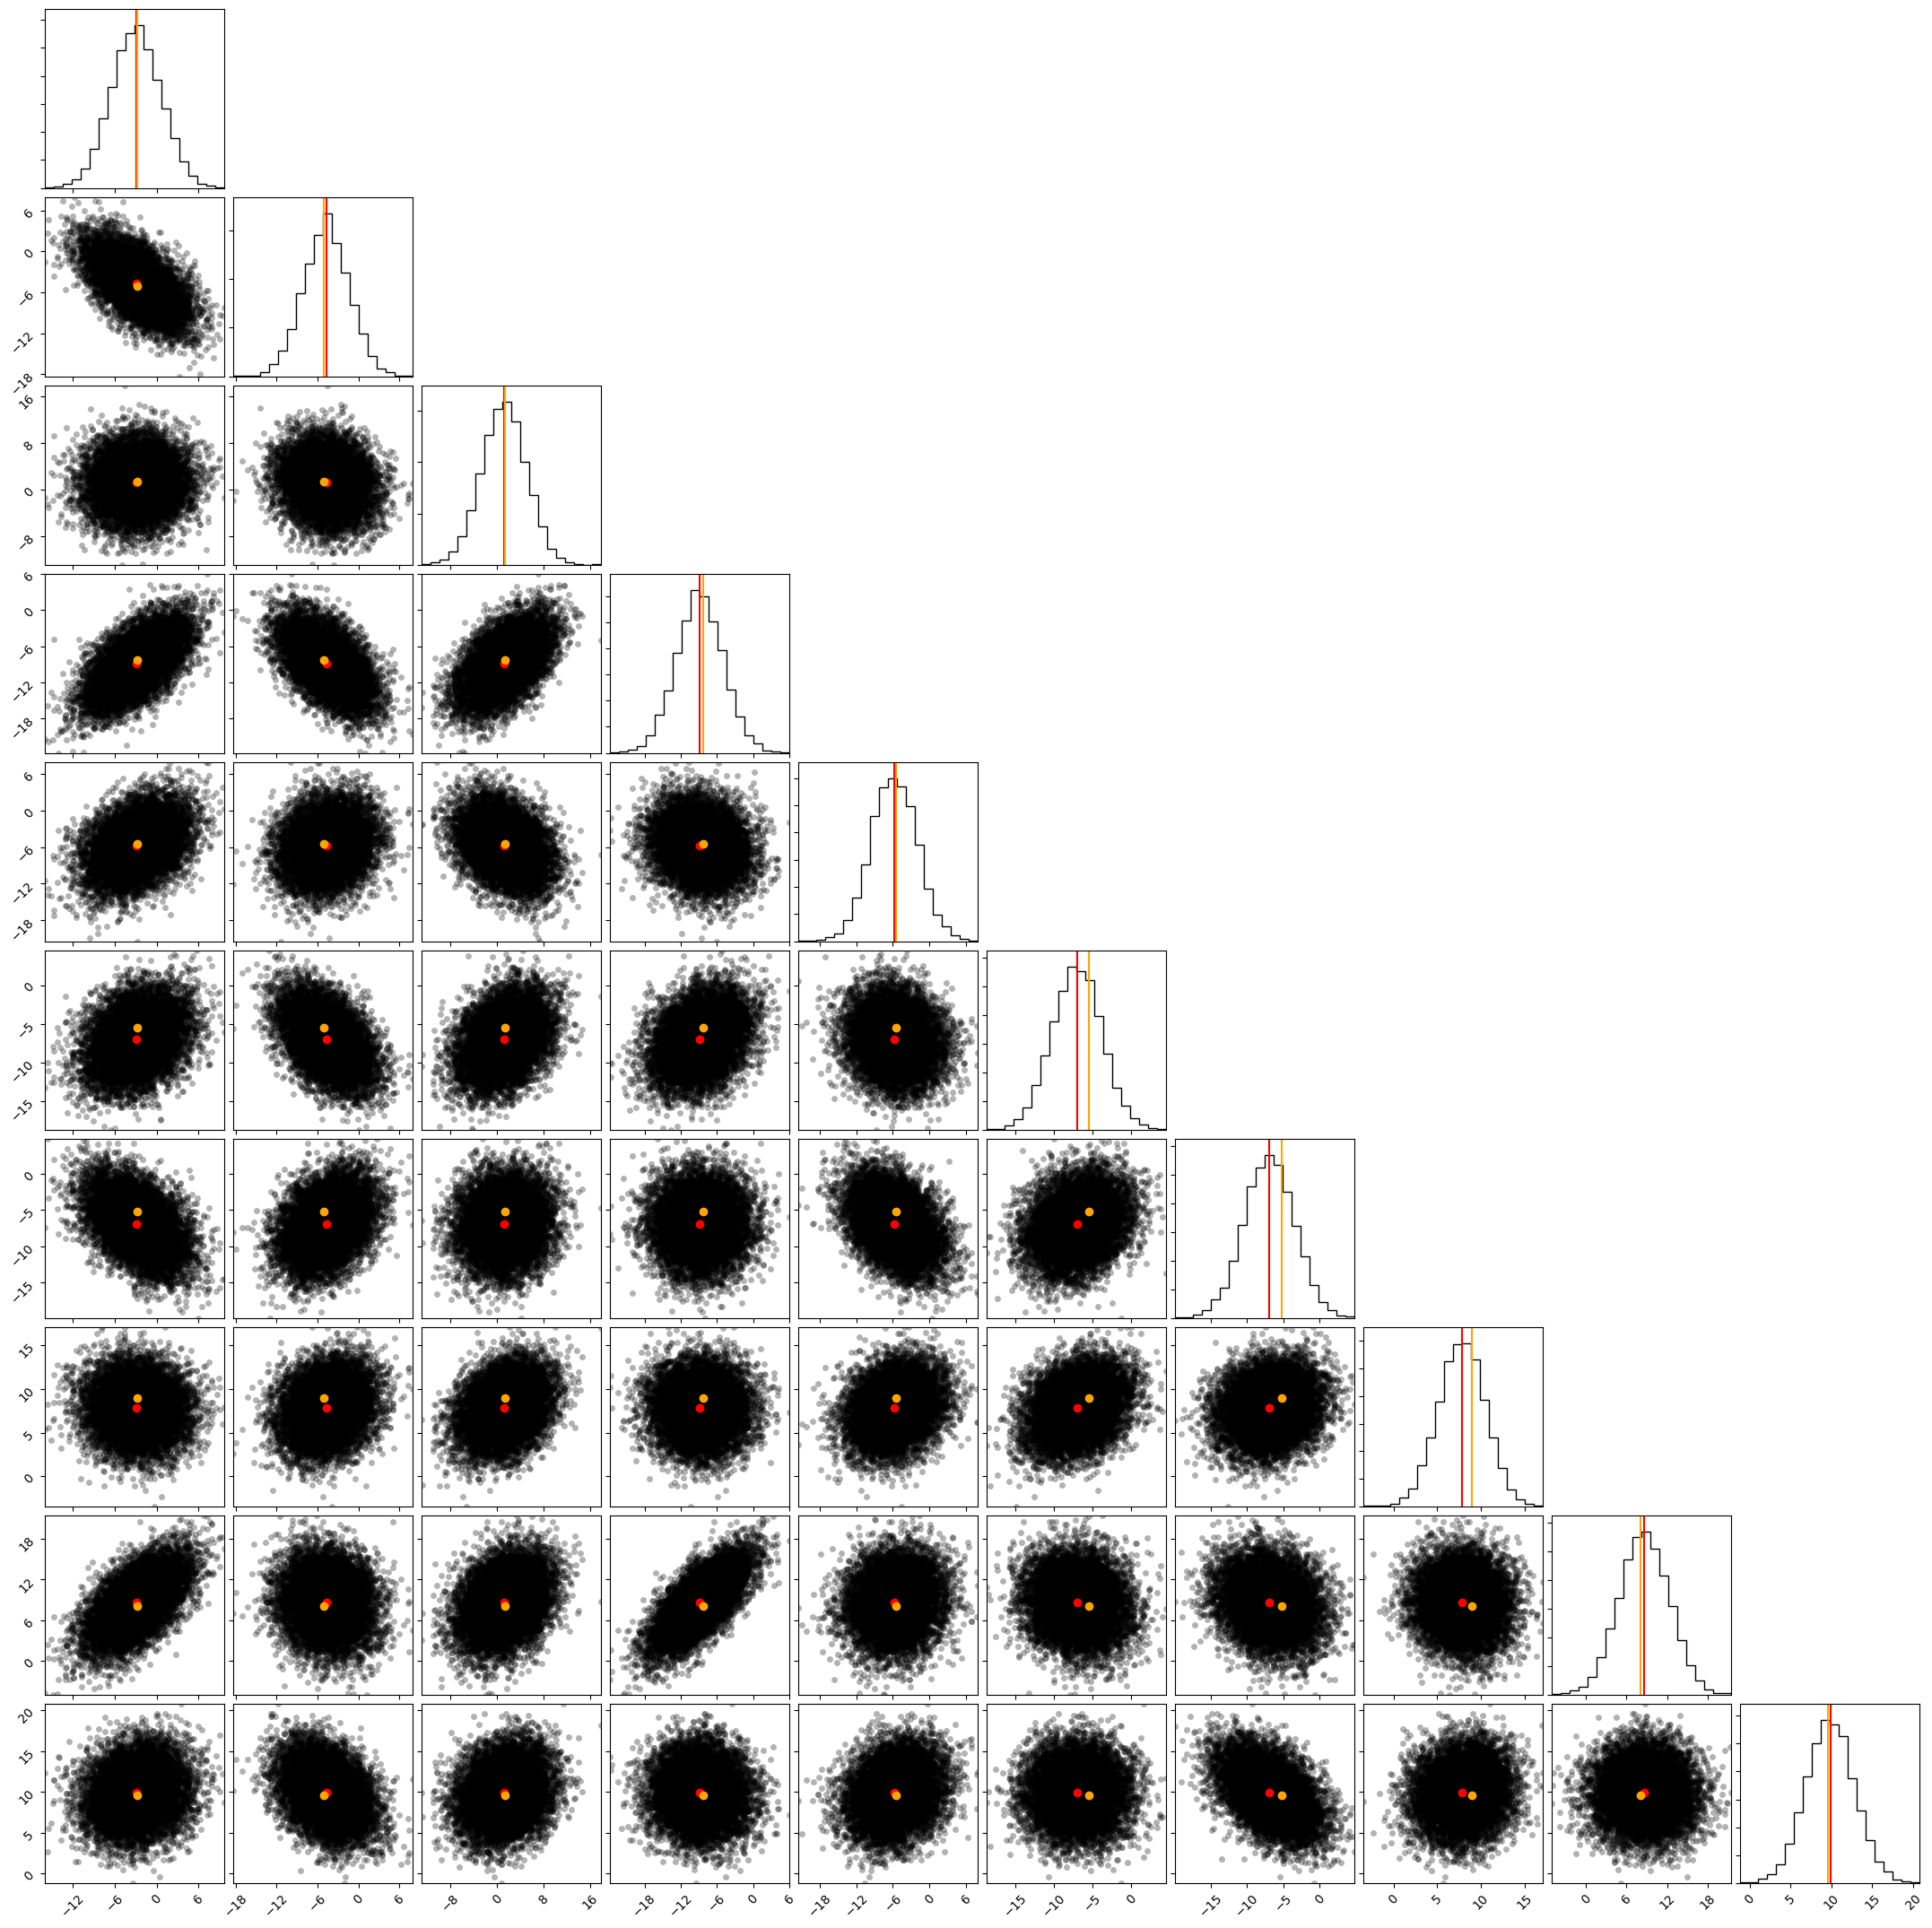

In [16]:
fig = corner(
    X,
    **dict(
        color="k",
        plot_density=False,
        plot_contours=False,
        data_kwargs=dict(ms=5, alpha=0.3),
    )
)
axes = np.array(fig.axes).reshape((ndim, ndim))
for row in range(ndim):
    for col in range(row + 1):
        ax = axes[row, col]
        if row==col:
            # On the main diagonal
            ax.axvline(mean[row], c="r")
            ax.axvline(X0[row], c="orange")
        else:
            ax.plot(*mean[[col, row]], "ro")
            ax.plot(*X0[[col, row]], "o", c="orange")
plt.show()

Additional note: It seems that the estimation using the log-probability gives better results.

# Generate artificial samples: Log-normal

I picked this distribution since it is skewed.
To generate multivariate distribution, I just use univariate lognormal distribution for each dimension and assume that each random variable is independent to each other.

In [17]:
ndim = 10
nsamples = 1000

X = np.empty((nsamples, ndim))
Q_per_dim = np.empty((nsamples, ndim))
mode = np.empty(ndim)
Qmax = 0.0

for nn in range(ndim):
    df = np.random.randint(3, 10)
    dist = stats.chi2(df)
    samples = dist.rvs(nsamples)
    X[:, nn] = samples
    Q_per_dim[:, nn] = dist.logpdf(samples)
    mode[nn] = df - 2
    Qmax += dist.logpdf(df - 2)
Q = np.sum(Q_per_dim, axis=1)

## Evaluation point: the actual maximum

In [18]:
X0 = mode
Q0 = np.array([Qmax])
S1_temp, S2_temp = sr.first_second_order(X0, Q0, X, Q)
S1 = S1_temp * np.exp(Q0)
S2 = np.exp(Q0) * (S2_temp + S1.T @ S1)

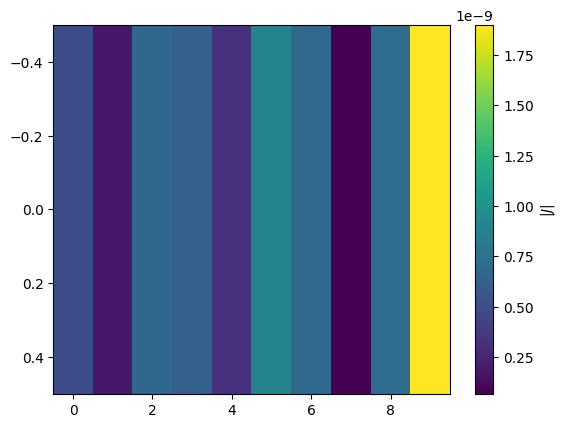

In [19]:
# Plot the Jacobian
plt.figure()
im = plt.imshow(np.abs(S1), aspect="auto")
clb = plt.colorbar(im)
clb.set_label(r"$\vert J \vert$")
plt.show()

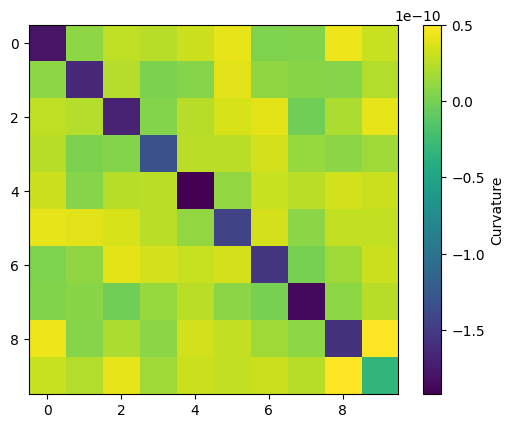

In [20]:
# Plot the curvature
plt.figure()
im = plt.imshow(S2[0])
clb = plt.colorbar(im)
clb.set_label("Curvature")
plt.show()

In [21]:
# Singular value of the Jacobian
print("Singular value of the Jacobian:", np.linalg.svd(S1, compute_uv=False))
# Eigenvalues of the curvature matrix
print("Eigenvalues of the Hessian:")
print(np.linalg.eigvalsh(S2[0]))

Singular value of the Jacobian: [2.57749023e-09]
Eigenvalues of the Hessian:
[-2.40144500e-10 -2.25620196e-10 -2.03783684e-10 -1.99184399e-10
 -1.82660302e-10 -1.64586116e-10 -1.48259120e-10 -1.32949332e-10
 -9.38438363e-11  8.12497363e-11]


## Evaluation point: the samples mean

In [22]:
idx_max = np.argmax(Q)
X0 = X[idx_max]
Q0 = np.array([Q[idx_max]])
S1_temp, S2_temp = sr.first_second_order(X0, Q0, X, Q)
S1 = S1_temp * np.exp(Q0)
S2 = np.exp(Q0) * (S2_temp + S1.T @ S1)

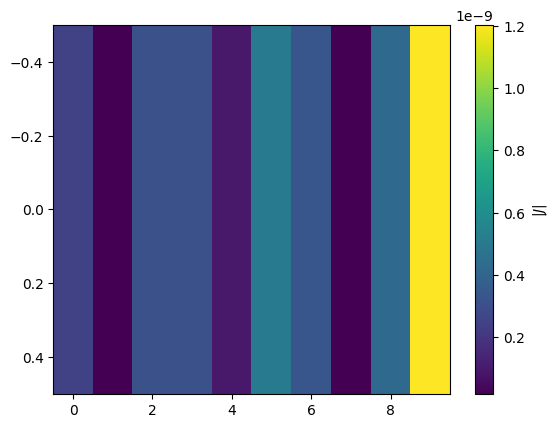

In [23]:
# Plot the Jacobian
plt.figure()
im = plt.imshow(np.abs(S1), aspect="auto")
clb = plt.colorbar(im)
clb.set_label(r"$\vert J \vert$")
plt.show()

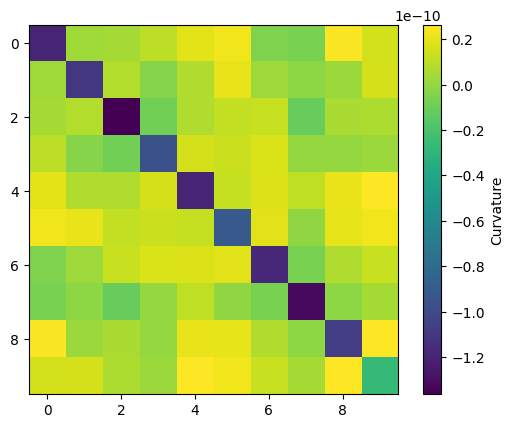

In [24]:
# Plot the curvature
plt.figure()
im = plt.imshow(S2[0])
clb = plt.colorbar(im)
clb.set_label("Curvature")
plt.show()

In [25]:
# Singular value of the Jacobian
print("Singular value of the Jacobian:", np.linalg.svd(S1, compute_uv=False))
# Eigenvalues of the curvature matrix
print("Eigenvalues of the Hessian:")
print(np.linalg.eigvalsh(S2[0]))

Singular value of the Jacobian: [1.50389266e-09]
Eigenvalues of the Hessian:
[-1.60325833e-10 -1.52076404e-10 -1.39302632e-10 -1.28265247e-10
 -1.22845484e-10 -1.14134369e-10 -1.00438455e-10 -9.17072445e-11
 -6.91142344e-11  2.14646006e-11]


In [26]:
# Compare the mean
print("Samples max:", X0)
print("Actual max:", mode)

Samples max: [3.71989748 5.27913243 4.17434433 3.17476543 4.66845546 2.12200647
 3.25280067 7.00130995 2.69761954 0.72024609]
Actual max: [4. 6. 3. 3. 6. 3. 3. 6. 3. 1.]


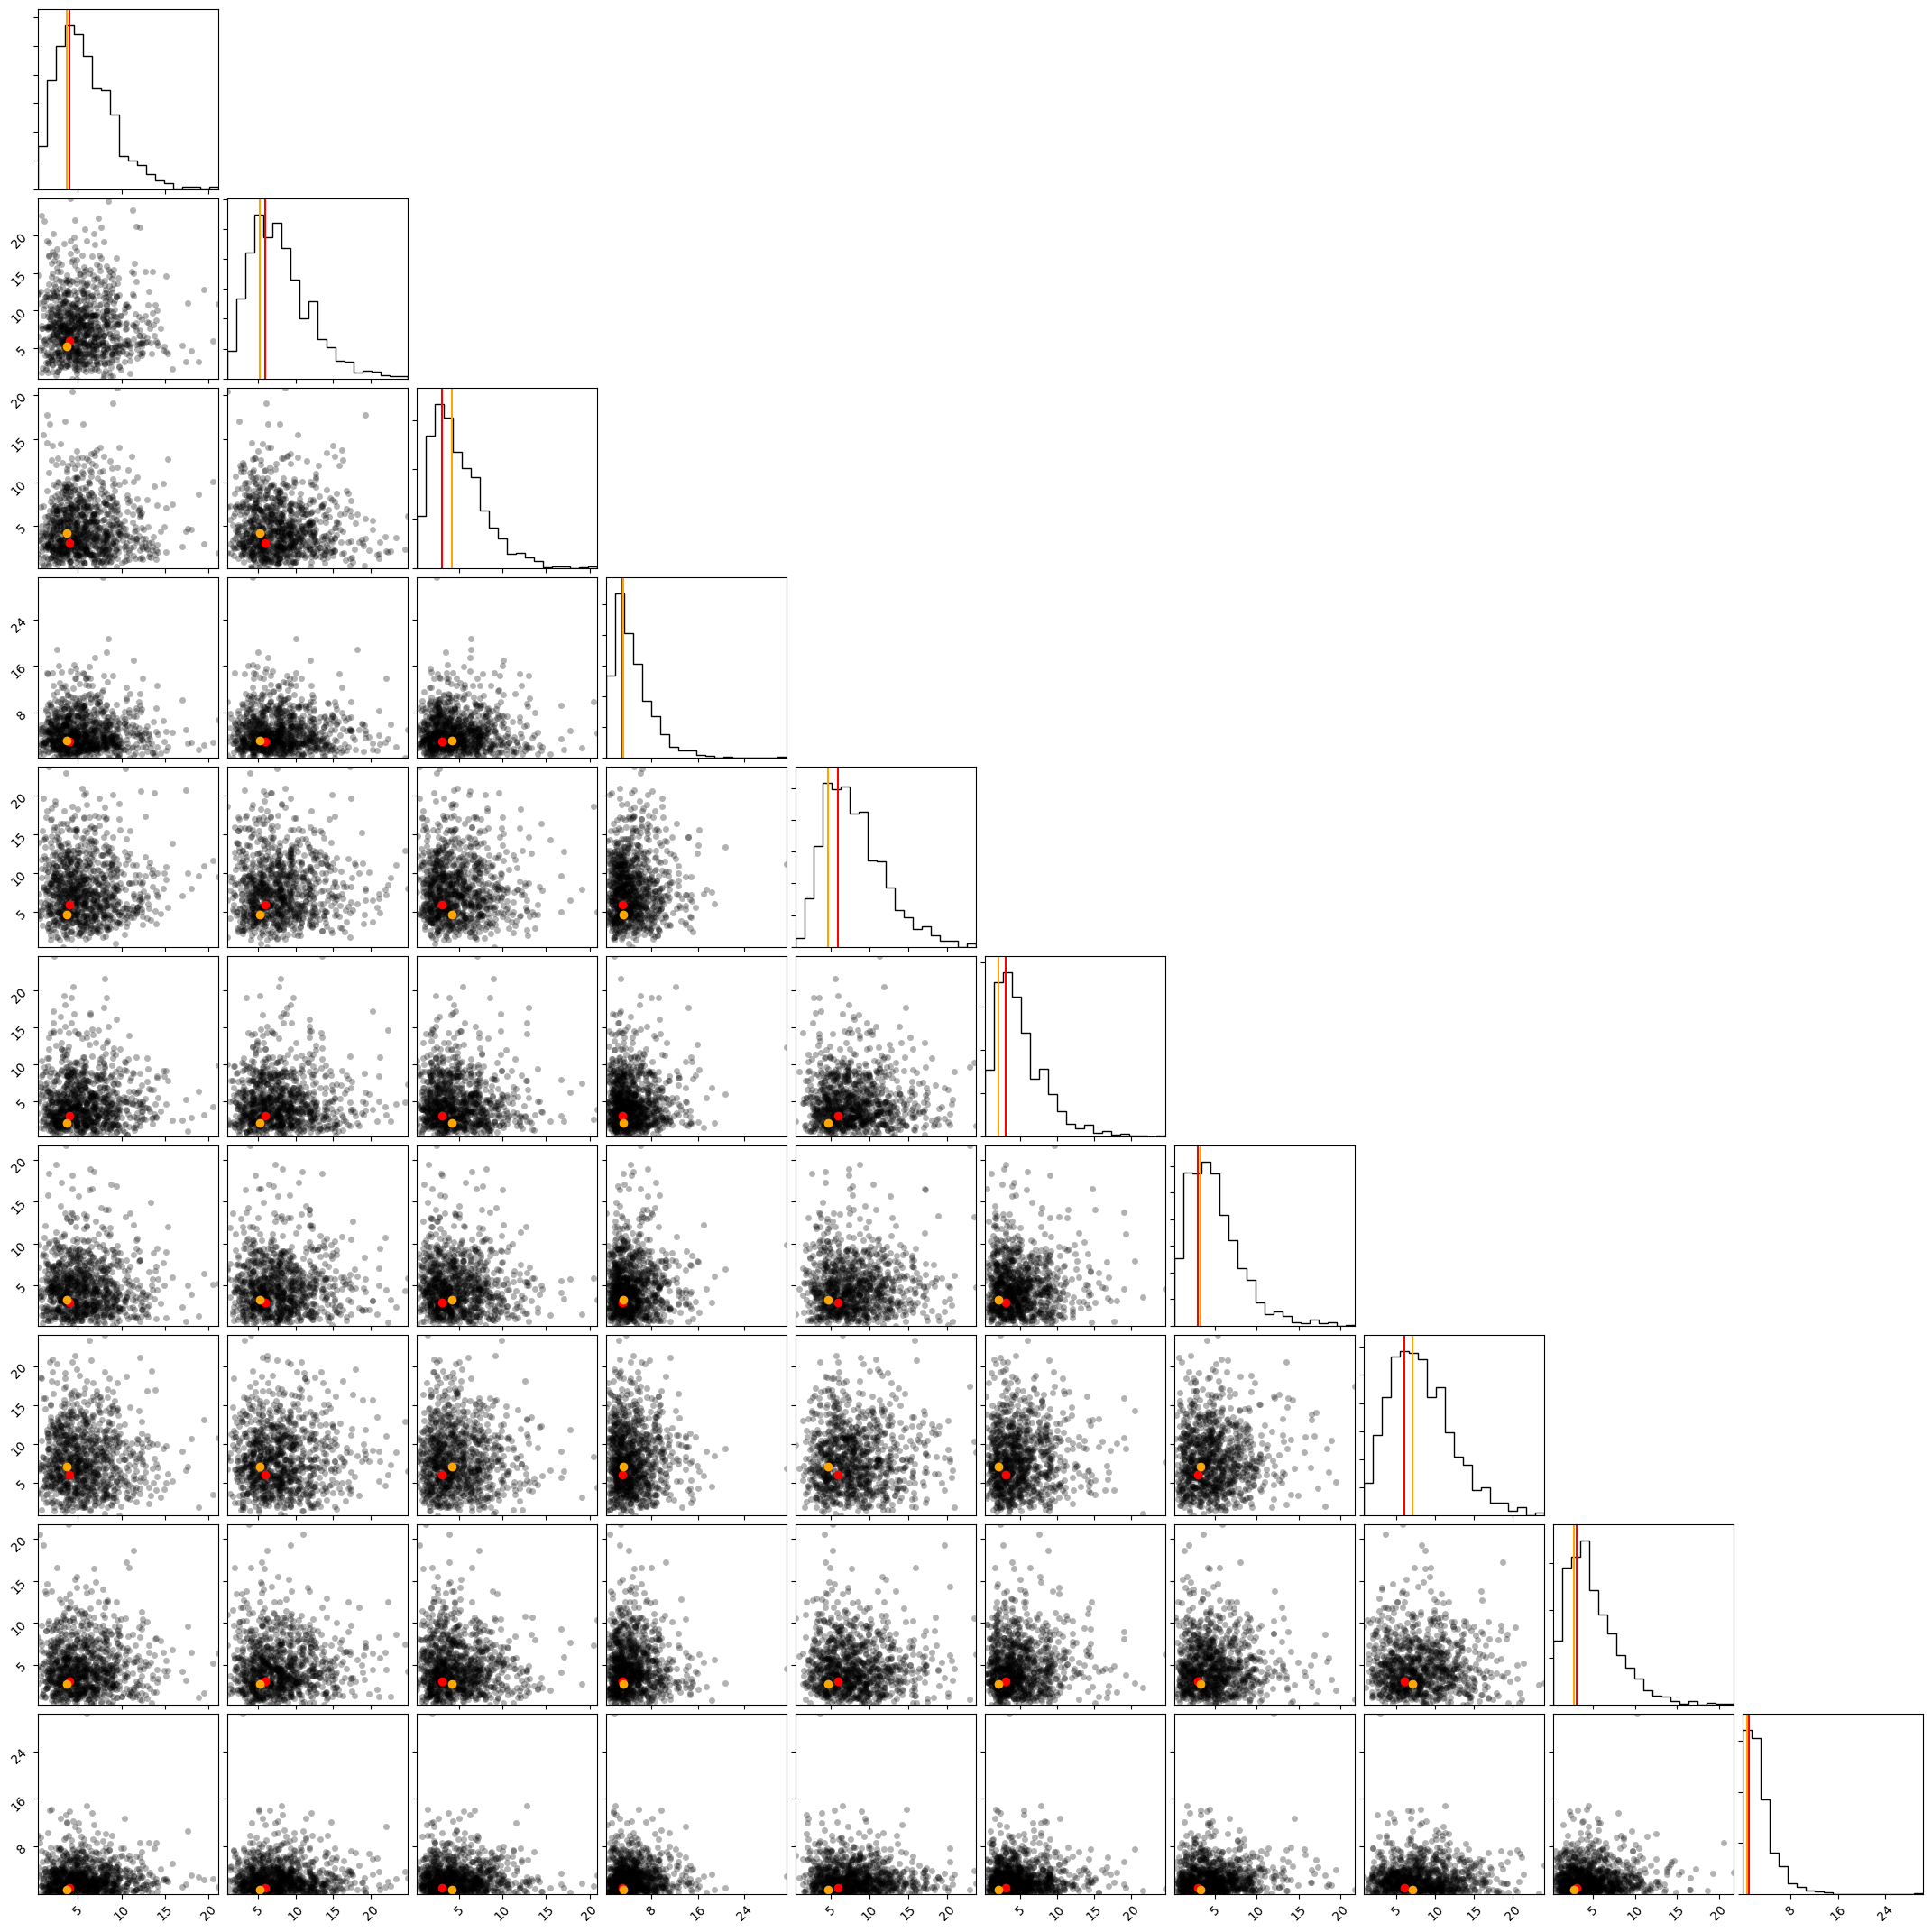

In [27]:
fig = corner(
    X,
    **dict(
        color="k",
        plot_density=False,
        plot_contours=False,
        data_kwargs=dict(ms=5, alpha=0.3),
    )
)
axes = np.array(fig.axes).reshape((ndim, ndim))
for row in range(ndim):
    for col in range(row + 1):
        ax = axes[row, col]
        if row==col:
            # On the main diagonal
            ax.axvline(mode[row], c="r")
            ax.axvline(X0[row], c="orange")
        else:
            ax.plot(*mode[[col, row]], "ro")
            ax.plot(*X0[[col, row]], "o", c="orange")
plt.show()

New thought: Currently, I just used the entire samples I generated from the toy probability model.
Note that the samples cover regions that are far enough from the mode.
In these regions, the Jacobians might not be zero and the Hessian might not be negative definite.

However, if the distribution is symmetric enough, the Jacobian would still average to zero.
For the case of the multivariate Gaussian, it seems that we have way more samples around the mode and the region with negative curvature, so that the estimated Hessian would still be negative definite.

For a non-symmetric distribution, such as the log-normal distribution, I don't expect the estimated Jacobian to be close to zero.
This might have the same effect on the estimated Hessian.

From the results that I got above, it might seem that the estimated Jacobian for the log-normal case is closer to zero compared to the multivariate Gaussian case.
However, I need to consider that the log-normal distribution is much wider in my case.
So, I need to consider this.

Additionally, the estimation using log-probability seem to give better results.
I think the estimation in log scale is just numerically more stable in this case, considering that the posterior values are often very small (close to zero).

# Back to multivariate Gaussian

In [28]:
ndim = 5
nsamples = 100_000

mean = np.random.uniform(-10, 10, ndim)
rand_mat = np.random.uniform(-2, 2, (ndim, ndim))
cov = rand_mat.T @ rand_mat
dist = stats.multivariate_normal(mean=mean, cov=cov, seed=seed)
X = dist.rvs(nsamples)
Q = dist.logpdf(X)
X0 = mean
Q0 = np.array([dist.logpdf(X0)])

In [29]:
rlist = np.logspace(-2, 1)[::-1]
sig_list = []
for ii, r in enumerate(rlist):
    Xs, idx = get_samples_subset(X, mean, r=r)
    Qs = Q[idx]
    try:
        S1_temp = sr.first_order(X0, Q0, Xs, Qs)
        S1 = S1_temp * np.exp(Q0)
        sig = np.linalg.norm(S1)  # np.linalg.svd(S1, compute_uv=False)
        sig_list = np.append(sig_list, sig)
    except Exception as e:
        print(r, e)
        rlist = rlist[:ii]
        break

0.3906939937054617 Please provide at least 5 samples


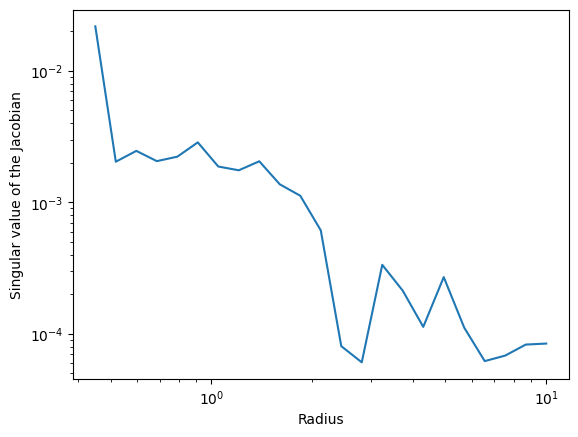

In [30]:
plt.figure()
plt.plot(rlist, sig_list)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius")
plt.ylabel("Singular value of the Jacobian")
plt.show()